# Version at 1AU and 4 Earth Masses

In [1]:
deposition_version = 2
load_dep = True

In [2]:
import numpy as np
import os 
from dedalus import public as de
from dedalus.extras.plot_tools import quad_mesh, pad_limits
import matplotlib.pyplot as plt
from scipy.special import erf 
import logging
logger = logging.getLogger(__name__)

%matplotlib inline

import time

# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

from dedalus.extras import plot_tools 

In [3]:
a_1 = 1
AU = 1.496e13
Mp = 4 # Earth masses
T_disk = 300 *a_1**(-1/2)

rho_disk = 2.4e-9*a_1**(-11/4)
r_Hill = 2e11*a_1*(Mp)**(1/3)
r_Bondi = 4e10*a_1**(1/2)*Mp

print('disk temperature: ' + str(T_disk))
print('disk density: ' + str(rho_disk))
print('hill radius: {:.4e}'.format(r_Hill))
print('bondi radius: {:.4e}'.format(r_Bondi))

disk temperature: 300.0
disk density: 2.4e-09
hill radius: 3.1748e+11
bondi radius: 1.6000e+11


In [4]:
# Basis and domain

resolution = 256 #500
# normalization factors
r_0 = 1.2e8
T_0 = 1000
P_0 = 1 #1e5 #1
M_0 = 1e-12
m_0 = 1e25
L_0 = 3.144546892817586e+27
Dep_0 = 5.972e27/3.154e7 

# r_outer = 1.496e13/r_0
r_outer = r_Hill /r_0 # 3.4199512e11/r_0
r_inner = 1.2e9/r_0

log_inner = np.log(r_inner) 
log_outer = np.log(r_outer)

log_basis = de.Chebyshev('r', resolution, interval=(log_inner,log_outer))  
domain = de.Domain([log_basis], np.float64)

In [5]:
# Problem

ncc_cutoff = 1e-6 #1e-2
tolerance = 1e-6 #1e-2
# P and T are actually log(P) and log(T)
problem = de.NLBVP(domain,variables = ['lgP', 'lgT', 'lgM', 'lgZgr','m', 'L'], ncc_cutoff = ncc_cutoff)
R = np.log10(np.exp(domain.grid(0))*r_0)

In [6]:
# Parameters

problem.parameters['T_0'] = T_0 
problem.parameters['r_0'] = r_0
problem.parameters['P_0'] = P_0 # unused
problem.parameters['M_0'] = M_0
problem.parameters['m_0'] = m_0
problem.parameters['Dep_0'] = Dep_0
problem.parameters['L_0'] = L_0

lgP = domain.new_field(name='lgP')
lgT = domain.new_field(name='lgT')
lgZgr = domain.new_field(name='lgZgr')
lgM = domain.new_field(name='lgM')
m = domain.new_field(name='m')
L = domain.new_field(name='L')

r = domain.new_field(name='R')
r['g'] = domain.grid(0)
S = np.exp(r['g']) * r_0
ones = np.ones(len(r['g']))

pi = np.pi 
Core_mass = Mp*5.972e27
Mc = Core_mass # 5* mass of earth (in g)
mu = 2.34 * 1.6735575e-24 #mH multiplied by hydrogen atom mass 
kb = 1.38064852e-16 # g*cm**2/(K*s**2)
G = 6.67408e-8 # cm**3/(g*s**2)
dMtot = 0.2*1e-5* 5.972e27/3.154e7 # 10e-5* mass of earth, g/s #3.154e7 is conversion from yr to s
sig = 5.670367e-5 # (cgs units) e-5 in g/(K^4s^3), Stefan Boltzmann Const (normally it's e-8 in [W⋅m−2⋅K−4])
s0 = 1e-4 # cm
rho_o = 3 #g cm^-3 grain internal density
sigma_b = 5.6704e-5 # erg*cm^-2*s^-1*K^-4 Stefan Boltzmann 
rcore = 1.2e9
grad_rad_cst = - 3*dMtot/(64*np.pi*rcore*sig)
gm = G*Mc 

# rhodisk = 1e-11 #g/cm**3
# Tdisk = 150 # kelvin

# # rhodisk = 4e-9 #g/cm**3
# # Tdisk = 370 # kelvin

rhodisk = rho_disk # 7.5e-9 #g/cm**3
Tdisk = T_disk # 370 # kelvin

mdep = rho_o * 4/3 * pi *(1e4)**3
dMdisk = 5e-9 * 5.972e27/3.154e7/30


problem.parameters['pi'] = np.pi
problem.parameters['Mc'] = Core_mass 
problem.parameters['mu'] = 2.34 * 1.6735575e-24 #mH multiplied by hydrogen atom mass 
problem.parameters['kb'] = 1.38064852e-16 # g*cm**2/(K*s**2)
problem.parameters['G'] = 6.67408e-8 # cm**3/(g*s**2)
problem.parameters['dMtot'] = 0.2*1e-5*5.972e27/3.154e7 # 10e-5* mass of earth, g/s #3.154e7 is conversion from yr to s
problem.parameters['sig'] = 5.670367e-5 # (cgs units) e-5 in g/(K^4s^3), Stefan Boltzmann Const (normally it's e-8 in [W⋅m−2⋅K−4])
problem.parameters['s0'] = 1e-4 # cm
problem.parameters['rho_o'] = 3 #g cm^-3 grain internal density
problem.parameters['mdep'] = problem.parameters['rho_o']*4/3*np.pi*(1e-4)**(3)
problem.parameters['sigma_b'] = 5.6704e-5 # erg*cm^-2*s^-1*K^-4 Stefan Boltzmann 
rcore = 1.2e9
problem.parameters['grad_rad_cst'] = - 3*problem.parameters['dMtot']/(64*np.pi*rcore*problem.parameters['sig'])


# problem.parameters['rhodisk'] = 4e-9 # 1e-11 #g/cm**3
# problem.parameters['Tdisk'] = 370 # 150 # kelvin

problem.parameters['rhodisk'] = rhodisk #g/cm**3
problem.parameters['Tdisk'] = Tdisk # kelvin

problem.substitutions['s'] = '(exp(lgM)*M_0*3/(4*pi*rho_o))**(1/3)' # radius
s = (np.exp(lgM)*M_0*3/(4*pi*rho_o))**(1/3)


# Deposition Type (3 versions) 

-22.515025306174465


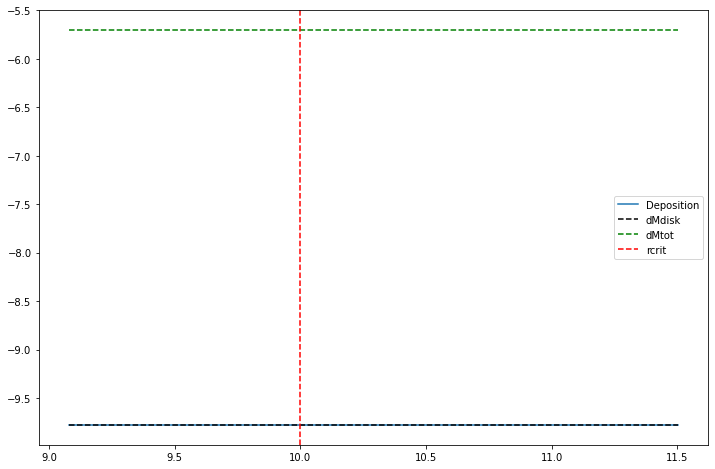

In [7]:
# # Mass deposition 
deposition_version = 'null'

if deposition_version == 0:
    lgdM = domain.new_field(name='lgdM')
    lgdM['g'] = np.loadtxt('M1dep.txt')

    d_r = log_basis.Differentiate(lgdM)
    dlgdM = d_r.evaluate()
    Mdep_fixed = lgdM['g']
    dlgdM_fixed = dlgdM['g']
    n_roll = Mdep_fixed.shape[0]//4
    Mdep_fixed_rolled =np.roll(Mdep_fixed, n_roll)
    dlgdM_fixed_rolled = np.roll(dlgdM_fixed, n_roll)

    # Correct leftmost values too low from wrapping around
    Mdep_fixed_rolled[:n_roll] = Mdep_fixed[0]
    dlgdM_fixed_rolled[:n_roll] = 0. # Zero gradient for constant value correction

    ones = lgdM['g']/lgdM['g']

    constant = np.log(ones*1e-5)
    dconstant = 0.*ones

    lgdM['g'] = Mdep_fixed_rolled
    dlgdM['g'] = dlgdM_fixed_rolled

    

elif deposition_version == 1:
    lgdM = domain.new_field(name='lgdM')
    lgdM['g'] = np.log(np.loadtxt('Deposition.txt')/Dep_0)
    d_r = log_basis.Differentiate(lgdM)
    dlgdM = d_r.evaluate()

elif deposition_version=='null':
    location = 10 # in log10 
    smooth = 3
    X = r['g'] - np.log(10**location/r_0) 
    lgdM = domain.new_field(name='lgdM')
    lgdM['g'] = X*0
    lgdM['g'] = lgdM['g']+np.log(dMdisk/Dep_0)
    print(np.log(dMdisk/Dep_0))
    # DEP = dMdisk + (dMtot-dMdisk)*((erf(smooth*eX['g']) + 1)/2)
    d_r = log_basis.Differentiate(lgdM)
    dlgdM = d_r.evaluate()

else:
    location = 10 # in log10 
    smooth = 3
    X = r['g'] - np.log(10**location/r_0) 
    lgdM = domain.new_field(name='lgdM')
    lgdM['g'] = np.log((dMdisk + (dMtot-dMdisk)*((-erf(smooth*X) + 1)/2))/Dep_0)    
    # DEP = dMdisk + (dMtot-dMdisk)*((erf(smooth*eX['g']) + 1)/2)
    d_r = log_basis.Differentiate(lgdM)
    dlgdM = d_r.evaluate()
    
problem.parameters['lgDep'] = lgdM
problem.parameters['dlgDep'] = dlgdM

lgDep = domain.new_field(name='lgDep')
dlgDep = domain.new_field(name='dlgDep')
lgDep['g'] = lgdM['g']
dlgDep['g'] = dlgdM['g']

plt.figure(figsize=(12,8))
plt.plot(R, np.log10(np.exp(lgdM['g'])), label='Deposition')
plt.plot(R, np.log10(ones*dMdisk/Dep_0), 'k--', label='dMdisk')
plt.plot(R, np.log10(ones*dMtot/Dep_0), 'g--', label='dMtot')
if deposition_version != 1 and deposition_version !=0:
    plt.axvline(location, color = 'r', ls='--', label='rcrit')
plt.legend()
# plt.plot(R, np.log10(np.exp(dlgdM['g'])))

In [8]:
# Opacity

problem.substitutions['x'] = '2*pi*s*0.3/0.2898'
x = 2*pi*s*0.3/0.2898

# min(2,ex*T*T_0) 
k0 = -10. # -30.
problem.parameters['k0'] = k0

problem.substitutions['Qe'] = "(0.5*(2**k0 + (x*exp(lgT)*T_0)**k0))**(1/k0)"
Qe = (0.5*(2**k0 + (x*np.exp(lgT)*T_0)**k0))**(1/k0)

problem.substitutions['Qk_geo'] = "Qe*3/4*exp(lgZgr)/(s*rho_o)" 
Qk_geo = Qe*3/4*np.exp(lgZgr)/(s*rho_o)

k_gas_cst = 1e-8*(problem.parameters["mu"]/problem.parameters['kb'])**(2/3) # O(10^-14)
problem.parameters['k_gas_cst'] = k_gas_cst

problem.substitutions['k_gas'] = "k_gas_cst*(exp(lgT)*T_0)**(7/3)*(exp(lgP)*P_0)**(2/3)" 
k_gas = k_gas_cst*(np.exp(lgT)*T_0)**(7/3)*(np.exp(lgP)*P_0)**(2/3)

problem.substitutions['kappa'] = "k_gas + Qk_geo"
kappa = k_gas + Qk_geo 

In [9]:
# Gradient  


# problem.substitutions['grad_rad'] = "grad_rad_cst*kappa*exp(lgP)*P_0/(exp(lgT)*T_0)**4"

grad_ad = 0.28
problem.parameters['grad_ad'] = grad_ad


# problem.substitutions['grad_rad'] = '-3*kappa*exp(L)*L_0/(64*pi*sigma_b*gm) * exp(lgP)*P_0/(exp(lgT)*T_0)**4'
problem.substitutions['grad_rad'] = '-3*kappa*L*L_0/(64*pi*sigma_b*gm) * exp(lgP)*P_0/(exp(lgT)*T_0)**4'
grad_rad = -3*kappa*L*L_0/(64*pi*sigma_b*gm) * np.exp(lgP)*P_0/(np.exp(lgT)*T_0)**4


# min
k1 = -10. # -30.
problem.parameters['k1'] = k1
problem.substitutions['grad'] = "(0.5*(grad_rad**k1 + (grad_ad)**k1))**(1/k1)" 
grad = (0.5*(grad_rad**k1 + (grad_ad)**k1))**(1/k1)

In [10]:
# Tstop: v_set = gm/r^2 * Tstop 

gm = problem.parameters['Mc']*problem.parameters['G']
problem.parameters['gm'] = gm

problem.substitutions['rho_g'] = '(exp(lgP)*P_0*mu)/(kb*exp(lgT)*T_0)'
rho_g = (np.exp(lgP)*P_0*mu)/(kb*np.exp(lgT)*T_0)

problem.substitutions['cg'] = 'sqrt(kb*exp(lgT)*T_0/mu)'
cg = np.sqrt(kb*np.exp(lgT)*T_0/mu)

problem.substitutions['Lg'] = '1e-9/rho_g'
Lg = 1e-9/rho_g

l = 30 #1 #15
problem.parameters['l'] = l

problem.substitutions['max'] = "(0.5*(1 + (s/Lg)**l))**(1/l)"
Max = (0.5*(1 + (s/Lg)**l))**(1/l)


problem.substitutions['Tstop'] = '(max*4*rho_o*s)/(9*cg*rho_g)'
Tstop = (Max*4*rho_o*s)/(9*cg*rho_g)

problem.substitutions['v_set'] = 'gm*Tstop/(exp(r)*r_0)**2'
v_set = gm*Tstop/(np.exp(r)*r_0)**2

In [11]:
# Tgrow 

problem.substitutions['v_bm'] = 'sqrt(16*kb*exp(lgT)*T_0/(pi*exp(lgM)*M_0))'
v_bm = np.sqrt(16*kb*np.exp(lgT)*T_0/(np.pi*np.exp(lgM)*M_0))

problem.substitutions['v_dd'] = '0.1*v_set'
v_dd = 0.1*v_set

problem.substitutions['Tgrow_inv'] = '3*exp(lgZgr)*rho_g*(v_bm+v_dd)/(rho_o*s)'
Tgrow_inv = 3*np.exp(lgZgr)*rho_g*(v_bm+v_dd)/(rho_o*s)

In [12]:
# Energy equation

# problem.substitutions['drho_dep'] = '-1/(4*pi*(exp(r)*r_0)**2) * dlgDep * 1e5'
problem.substitutions['drho_dep'] = '-1/(4*pi*(exp(r)*r_0)**3) * dlgDep * Dep_0 * exp(lgDep)'
drho_dep = -1/(4*pi*(np.exp(r)*r_0)**3) * dlgDep * Dep_0 * np.exp(lgDep)

Trelax = 1e30
problem.parameters['Trelax'] = Trelax

Lcore = problem.parameters['gm']*problem.parameters['dMtot']/(r_inner*r_0)
problem.parameters['Lcore'] = Lcore
print(problem.parameters['Lcore'])

5.031275028508138e+26


In [13]:
# New equations

problem.add_equation('lgZgr = log(exp(lgDep)*Dep_0/(4*pi*gm*Tstop*rho_g))')
# problem.add_equation('lgZgr = log(dMdep/(4*pi*gm*Tstop*rho_g))')
problem.add_equation('dr(lgM) = -Tgrow_inv*(exp(r)*r_0)**3/(gm*Tstop) + dlgDep*(mdep-exp(lgM)*M_0)/(exp(lgM)*M_0)')

In [14]:
# Normalized equations

# problem.parameters['eq1cst'] = -1*problem.parameters['G']*problem.parameters['Mc']*problem.parameters['mu']/(T_0*r_0*problem.parameters['kb'])
problem.add_equation('dr(m) = 4*pi*(exp(r)*r_0)**3 * rho_g/m_0')
problem.add_equation('exp(r) * dr(lgP) = -G*(Mc+m*m_0)*mu/(T_0*r_0*kb*exp(lgT))')
problem.add_equation('dr(lgT) = dr(lgP)*grad')

# problem.add_equation('dr(L) = 4*pi*(exp(r)*r_0)* (G*(Mc+m*m_0)*drho_dep/(exp(r)*r_0))')
# problem.add_equation('dr(L)*L_0 = 4*pi*(exp(r)*r_0)**3 * (G*(Mc+m*m_0)*drho_dep/(exp(r)*r_0) + rho_g*cg*(exp(lgT)*T_0 - Tdisk)/Trelax )')
problem.add_equation('dr(L)*L_0 = (4*pi*(exp(r)*r_0)**3 * (G*(Mc+m*m_0)*drho_dep/(exp(r)*r_0) + rho_g*cg*(exp(lgT)*T_0 - Tdisk)/Trelax ))')


In [15]:
# Boundary Equations


problem.add_bc("right(lgT) = log(Tdisk/T_0)") # disk temp in kelvins
problem.add_bc("right(lgP) = log(rhodisk*kb*Tdisk/mu/P_0)") # gas law
problem.add_bc("right(lgZgr) = log(1e-3)")
problem.add_bc("left(m) = 0")
problem.add_bc("left(L) = Lcore/L_0")

In [16]:
# solver = problem.build_solver(de.timesteppers.RK443)
solver = problem.build_solver()

2021-12-30 11:31:14,372 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+02/s


Text(0.5, 1.0, 'm')

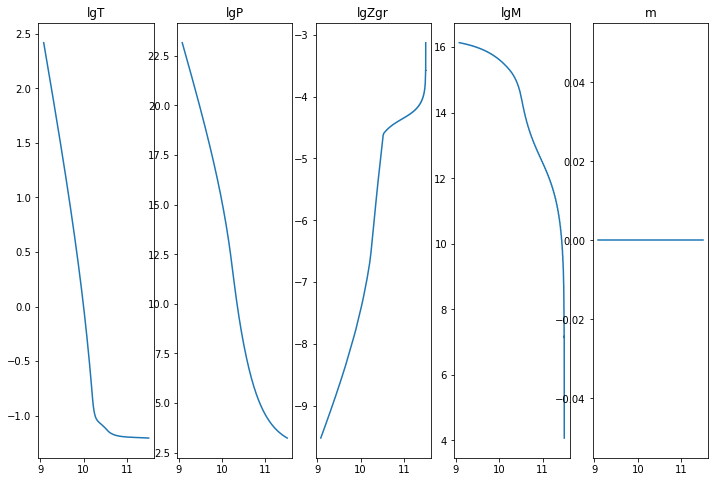

In [17]:
# initial conditions and referencing local grid state fields

lgr = domain.grid(0)
Rscale = np.log10(np.exp(domain.grid(0))*r_0)
lgT1 = solver.state['lgT']
lgP1 = solver.state['lgP']
lgZgr1 = solver.state['lgZgr']
lgM1 = solver.state['lgM']

L1 = solver.state['L']
m1= solver.state['m']

# Load from constant Mass and Zgr version

lgP_initial = np.loadtxt("Pressure.txt")
lgT_initial = np.loadtxt("Temperature.txt")
Zi = np.loadtxt('Zgr.txt')
Mi = np.loadtxt('M.txt')

lgP1['g'] = lgP_initial
lgT1['g'] = lgT_initial
ones = lgT1['g']/lgT1['g']

L1['g'] = ones*problem.parameters['Lcore']/L_0

lgZgr1['g'] = Zi 

lgM1['g'] = Mi
m1['g'] = ones*0


if load_dep: 
    lgP1['g'] = np.loadtxt("NPressure_dep.txt")
    lgT1['g'] = np.loadtxt("NTemperature_dep.txt")
    L1['g'] = np.loadtxt('NL_dep.txt')
    lgZgr1['g'] = np.loadtxt('NZgr_dep.txt') 
    lgM1['g'] = np.loadtxt('NM_dep.txt')
    m1['g'] = np.loadtxt('Nm_dep.txt')
    
    
plt.figure(figsize=(12,8))
plt.subplot(1,5,1)
plt.plot(Rscale,lgT1['g'])
plt.title("lgT")
plt.subplot(1,5,2)
plt.plot(Rscale, lgP1['g'])
plt.title("lgP")
plt.subplot(1,5,3)
plt.plot(Rscale, np.log10(np.exp(lgZgr1['g'])))
plt.title("lgZgr")
plt.subplot(1,5,4)
plt.plot(Rscale, lgM1['g'])
plt.title("lgM")
plt.subplot(1,5,5)
plt.plot(Rscale, m1['g'])
plt.title("m")

In [18]:

lgT_list = [np.copy(lgT1['g'])]
lgP_list = [np.copy(lgP1['g'])]
lgZgr_list = [np.copy(lgZgr1['g'])]
lgM_list = [np.copy(lgM1['g'])]
m_list = [np.copy(m1['g'])]
L_list = [np.copy(L1['g'])]

2021-12-30 11:31:16,611 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.0e+00/s
2021-12-30 11:31:16,987 __main__ 0/1 INFO :: Perturbation norm: 479.81776290581644
2021-12-30 11:31:16,988 __main__ 0/1 INFO :: lgT iterate: 2.4174299019860226
2021-12-30 11:31:16,990 __main__ 0/1 INFO :: lgP iterate: 23.166213411569558
2021-12-30 11:31:16,993 __main__ 0/1 INFO :: lgM iterate: 16.13810153211866
2021-12-30 11:31:16,994 __main__ 0/1 INFO :: lgZgr iterate: -21.92644711541003
2021-12-30 11:31:16,995 __main__ 0/1 INFO :: m iterate: 0.0033183340125617633
2021-12-30 11:31:16,996 __main__ 0/1 INFO :: L iterate: 0.1599999999999974


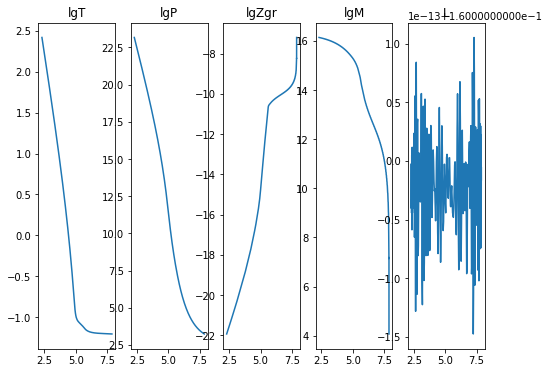

2021-12-30 11:31:18,877 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.3e+00/s
2021-12-30 11:31:19,241 __main__ 0/1 INFO :: Perturbation norm: 6.589234912436685e-06
2021-12-30 11:31:19,243 __main__ 0/1 INFO :: lgT iterate: 2.417429901756942
2021-12-30 11:31:19,245 __main__ 0/1 INFO :: lgP iterate: 23.166213403877908
2021-12-30 11:31:19,246 __main__ 0/1 INFO :: lgM iterate: 16.13810153664599
2021-12-30 11:31:19,247 __main__ 0/1 INFO :: lgZgr iterate: -21.926447111087516
2021-12-30 11:31:19,248 __main__ 0/1 INFO :: m iterate: 0.0033183331408963568
2021-12-30 11:31:19,249 __main__ 0/1 INFO :: L iterate: 0.16000000000000003


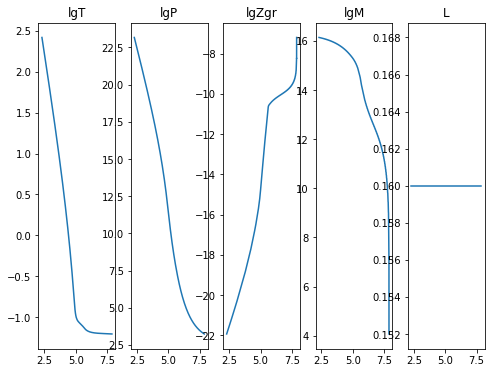

2021-12-30 11:31:21,223 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.2e+00/s
2021-12-30 11:31:21,659 __main__ 0/1 INFO :: Perturbation norm: 6.751645086563043e-07
2021-12-30 11:31:21,660 __main__ 0/1 INFO :: lgT iterate: 2.4174299017067358
2021-12-30 11:31:21,661 __main__ 0/1 INFO :: lgP iterate: 23.16621340293168
2021-12-30 11:31:21,663 __main__ 0/1 INFO :: lgM iterate: 16.138101533273492
2021-12-30 11:31:21,664 __main__ 0/1 INFO :: lgZgr iterate: -21.926447107965018
2021-12-30 11:31:21,665 __main__ 0/1 INFO :: m iterate: 0.0033183311834932283
2021-12-30 11:31:21,666 __main__ 0/1 INFO :: L iterate: 0.16


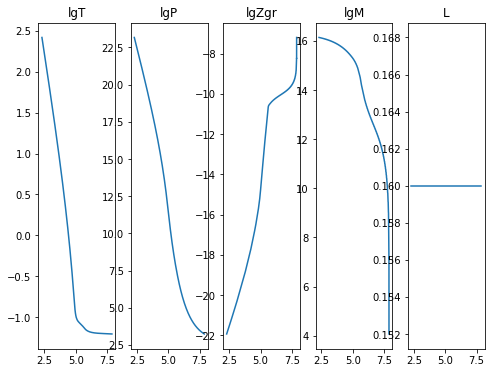

In [19]:
# Iterations

i = 0

pert = solver.perturbations.data
pert.fill(1+tolerance)
start_time = time.time()
while np.sum(np.abs(pert)) > tolerance:
    solver.newton_iteration()
    lgT_list.append(np.copy(lgT1['g'])) # save
    lgP_list.append(np.copy(lgP1['g']))
    lgZgr_list.append(np.copy(lgZgr1['g'])) 
    lgM_list.append(np.copy(lgM1['g'])) 
    L_list.append(np.copy(L1['g']))
    m_list.append(np.copy(m['g']))
    logger.info('Perturbation norm: {}'.format(np.sum(np.abs(pert))))
    logger.info('lgT iterate: {}'.format(lgT1['g'][0]))
    logger.info('lgP iterate: {}'.format(lgP1['g'][0]))
    logger.info('lgM iterate: {}'.format(lgM1['g'][0]))
    logger.info('lgZgr iterate: {}'.format(lgZgr1['g'][0]))
    logger.info('m iterate: {}'.format(m1['g'][0]))
    logger.info('L iterate: {}'.format(L1['g'][0]))
    
    plt.figure(figsize=(8,6))
    plt.subplot(1,5,1)
    plt.plot(domain.grid(0),lgT1['g'])
    plt.title("lgT")
    plt.subplot(1,5,2)
    plt.plot(domain.grid(0), lgP1['g'])
    plt.title("lgP")
    plt.subplot(1,5,3)
    plt.plot(domain.grid(0),lgZgr1['g'])
    plt.title("lgZgr")
    plt.subplot(1,5,4)
    plt.plot(domain.grid(0), lgM1['g'])
    plt.title("lgM")
    plt.subplot(1,5,5)
    plt.plot(domain.grid(0), L1['g'])
    plt.title("L")
    plt.show()
    
end_time = time.time()

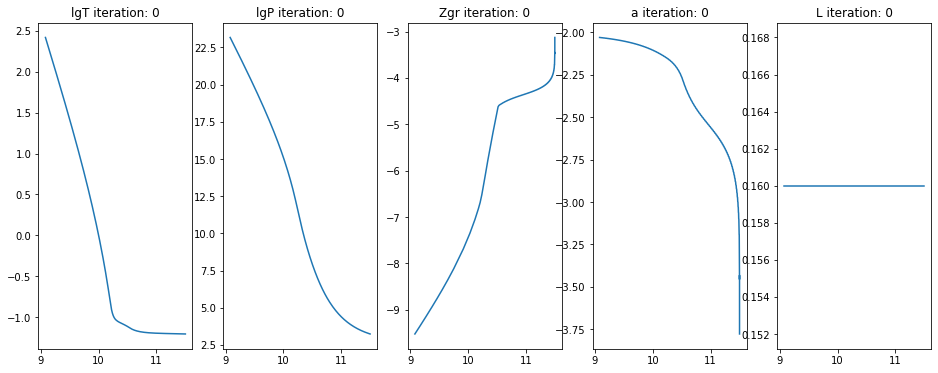

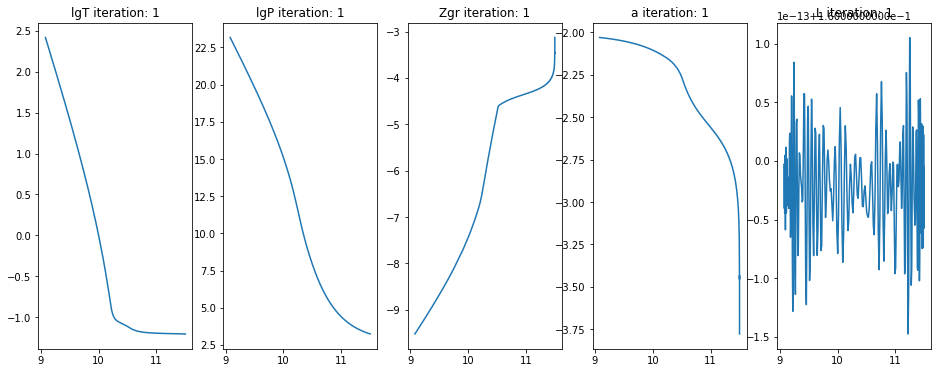

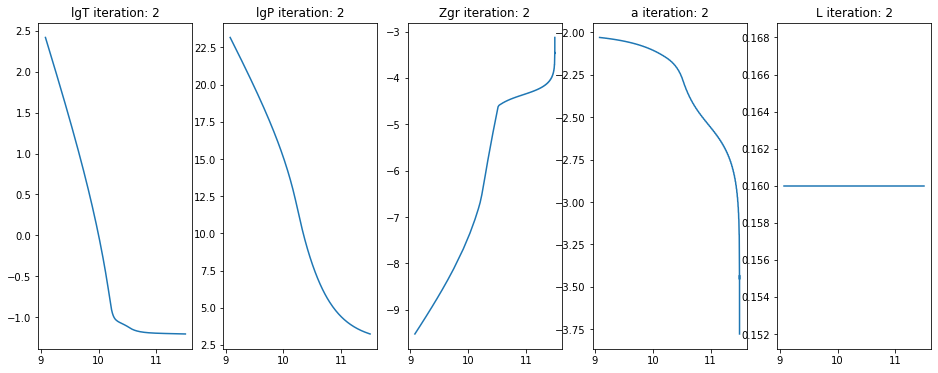

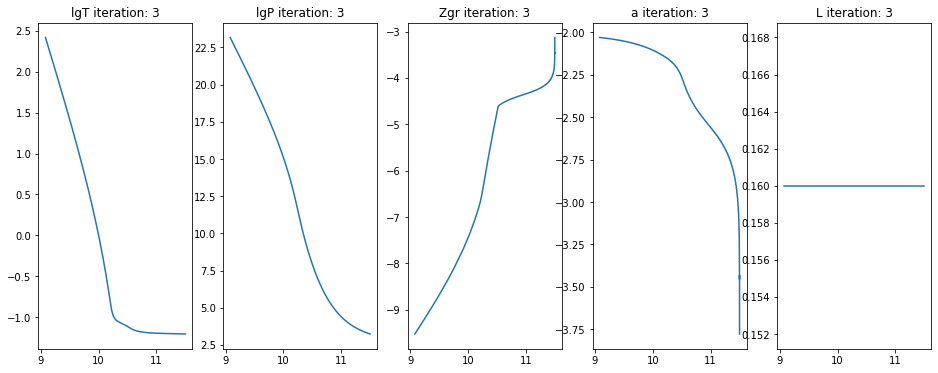

In [20]:
lower = 0 
if len(lgT_list) > 20:
    lower = len(lgT_list) - 20

R = np.log10(np.exp(domain.grid(0))*r_0)

for i in range(lower,len(lgT_list)):
        plt.figure(figsize=(16,6))
        
        plt.subplot(1,5,1)
        plt.plot(R,lgT_list[i])
        plt.title("lgT iteration: " + str(i))
        
        plt.subplot(1,5,2)
        plt.plot(R, lgP_list[i])
        plt.title("lgP iteration: " + str(i))
        
        plt.subplot(1,5,3)
        plt.plot(R, np.log10(np.exp(lgZgr_list[i])))
        plt.title("Zgr iteration: " + str(i))
        
        # Grain size 
        plt.subplot(1,5,4)
        plt.plot(R, np.log10((np.exp(lgM_list[i])*M_0/(4*np.pi))**(1/3)))
        plt.title("a iteration: " + str(i))
        
#         plt.subplot(1,5,5)
#         plt.plot(R, m_list[i])
#         plt.title("m iteration: " + str(i))

        plt.subplot(1,5,5)
        plt.plot(R, L_list[i])
        plt.title("L iteration: " + str(i))
        
        

In [21]:
lgP['g'] = lgP_list[-1]
lgT['g'] = lgT_list[-1]
lgZgr['g'] = lgZgr_list[-1]
lgM['g'] = lgM_list[-1]
m['g'] = m_list[-1]
L['g'] = L_list[-1]

Text(0.5, 1.0, 'Grad')

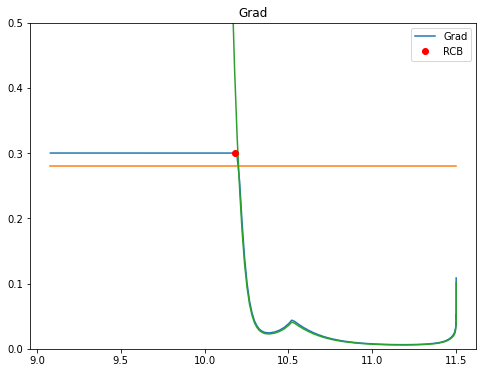

In [22]:
# Grad

Grad = grad.evaluate()
Grad.require_grid_space()
Grad_rad = grad_rad.evaluate()
Grad_rad.require_grid_space()

RCB = 0
epsilon = 0.0001
for i in range(0, len(Grad['g'] - 1)):
    if np.abs(Grad['g'][i] - Grad['g'][0]) >  epsilon:
        RCB = i
        break

plt.figure(figsize=(8,6))
plt.plot(R, Grad['g'], label='Grad')
plt.plot(R, grad_ad*np.ones(len(R)))
plt.plot(R, -Grad_rad['g'])
plt.plot(R[RCB], Grad['g'][RCB], 'ro', label = 'RCB')
plt.ylim(0, 0.5)
plt.legend()

plt.title('Grad')

Text(0.5, 1.0, 'Tstop')

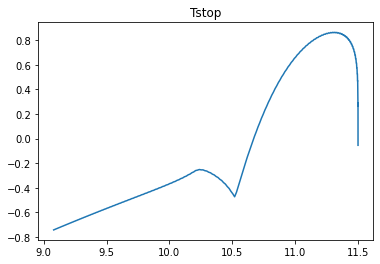

In [23]:
TStop = Tstop.evaluate()
TStop.require_grid_space()
plt.plot(R, np.log10(TStop['g']))
plt.title('Tstop')

Text(0.5, 1.0, 'Tgrow')

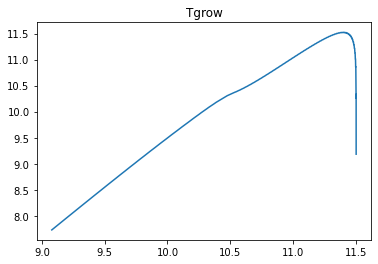

In [24]:
Tgrow = 1/Tgrow_inv
TGrow = Tgrow.evaluate()
TGrow.require_grid_space()
plt.plot(R, np.log10(TGrow['g']))
plt.title('Tgrow')

# New analysis section (Jan 30)


Trcb_set = 47.34464124608265 yr
Tbondi_set = 6515.518936570736 yr
Tout_set = 39094.51583118114 yr


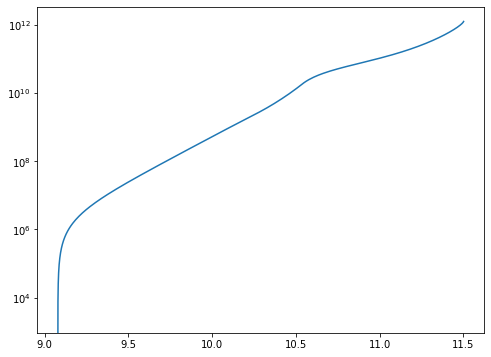

In [25]:
Bondi = r_Bondi # cm
# Bondi = 3.7e11 # cm
# Tsettl = r/vsettl 
def find_nearest_index(A, x):
    i = (np.abs(A - x)).argmin()
    return i

bondi = find_nearest_index(R, np.log10(Bondi))
Vsettl = v_set.evaluate()
Vsettl.require_grid_space()
Vset = Vsettl['g']

Tsettl = np.ones(len(R))

for i in range(0, len(R)):
    Tsettl[i] = np.trapz(1/Vset[0:i], S[0:i]) # Ormel integral definition 
    
# Tsettl = np.exp(r['g'])*r_0/Vset 
    
plt.figure(figsize=(8,6))
plt.plot(R, Tsettl)
plt.yscale('log')


Trcb_set = Tsettl[RCB]
Tbondi_set = Tsettl[bondi]
Tout_set = Tsettl[-1]

yr = 3.154e+7

print("Trcb_set = {} yr".format(Trcb_set/yr))
print("Tbondi_set = {} yr".format(Tbondi_set/yr))
print("Tout_set = {} yr".format(Tout_set/yr))



Trcb_set = 47.34464124608265 yr
Tbondi_set = 2887.409002660573 yr
Tout_set = 39094.51583118114 yr


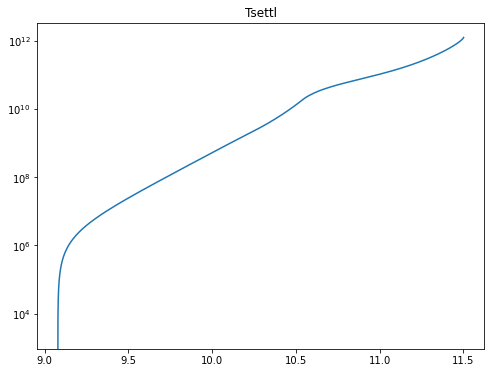

In [26]:
Bondi = 3.7e11 # cm
Bondi = 8.9442713e10
# Tsettl = r/vsettl 
def find_nearest_index(A, x):
    i = (np.abs(A - x)).argmin()
    return i

bondi = find_nearest_index(R, np.log10(Bondi))
Vsettl = v_set.evaluate()
Vsettl.require_grid_space()
Vset = Vsettl['g']


Tsettl = np.ones(len(R))


for i in range(0, len(R)):
    Tsettl[i] = np.trapz(1/Vset[0:i], S[0:i]) # Ormel integral definition 
    
# Tsettl = np.exp(r['g'])*r_0/Vset 
    
plt.figure(figsize=(8,6))
plt.plot(R, Tsettl)
plt.yscale('log')
plt.title('Tsettl')

Trcb_set = Tsettl[RCB]
Tbondi_set = Tsettl[bondi]
Tout_set = Tsettl[-1]

yr = 3.154e+7

print("Trcb_set = {} yr".format(Trcb_set/yr))
print("Tbondi_set = {} yr".format(Tbondi_set/yr))
print("Tout_set = {} yr".format(Tout_set/yr))

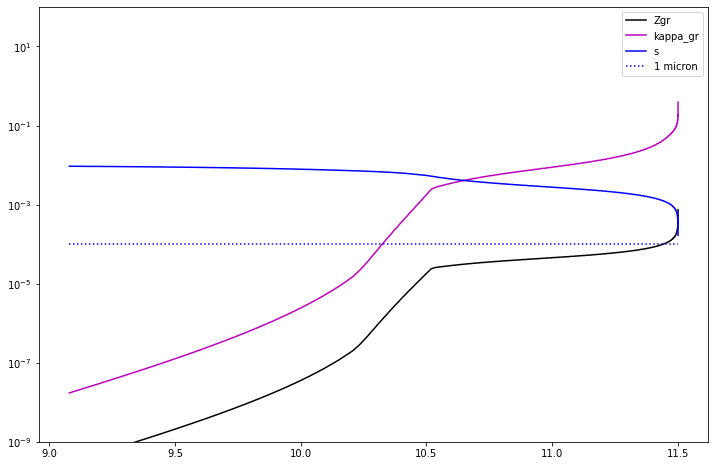

In [27]:
# Ormel profile
size = s.evaluate()
size.require_grid_space()
kappa_gr = Qk_geo.evaluate()
kappa_gr.require_grid_space()


plt.figure(figsize=(12,8))
plt.plot(R, np.exp(lgZgr['g']), 'k-', label='Zgr')
plt.plot(R, kappa_gr['g'], 'm-', label='kappa_gr')
plt.plot(R, size['g'], 'b-', label='s')
plt.plot(R, R/R*1e-4, 'b:', label='1 micron')
plt.yscale('log')
plt.ylim((1e-9, 1e2))
plt.legend()

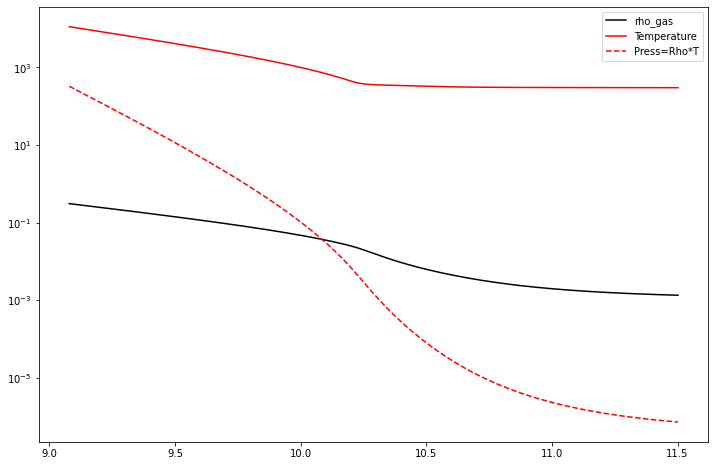

In [28]:
rho_gas = rho_g.evaluate()
rho_gas.require_grid_space()

lgt = lgT_list[-1]


plt.figure(figsize=(12,8)) # I don't know Ormel's normalization values 
plt.plot(R, (rho_gas['g'])**(1/3), 'k-', label='rho_gas')
plt.plot(R, np.exp(lgt)*T_0, 'r-', label='Temperature') 
plt.plot(R, np.exp(lgt)*T_0 *rho_gas['g'] , 'r--', label='Press=Rho*T')
plt.yscale('log')
plt.legend()

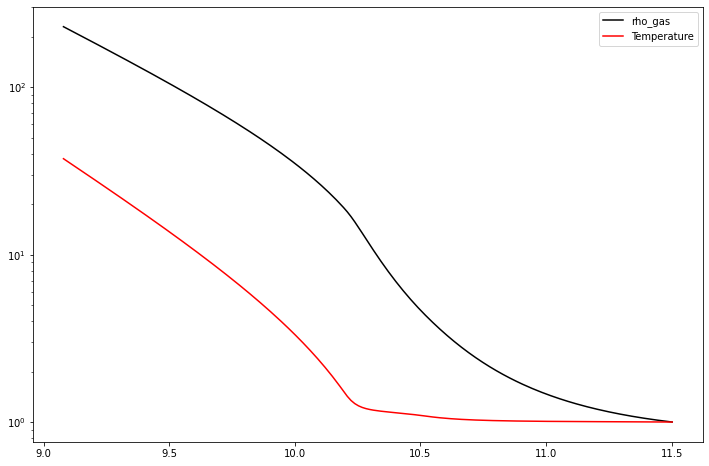

In [29]:
plt.figure(figsize=(12,8)) # I don't know Ormel's normalization values 
plt.plot(R, (rho_gas['g']/rhodisk)**(1/3) , 'k-', label='rho_gas')
plt.plot(R, np.exp(lgt)*T_0 / Tdisk, 'r-', label='Temperature') 
plt.yscale('log')
plt.legend()

Envelope mass (g): 3.531610e+27


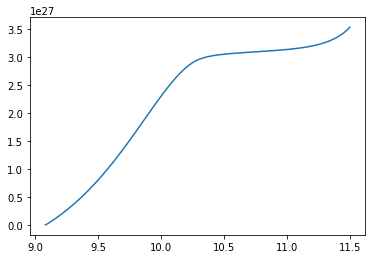

In [30]:
Env = np.zeros(len(R))

En = 4*np.pi*(np.exp(r)*r_0)**2 *rho_g 

m = En.evaluate()
m.require_grid_space()

for i in range(0, len(R)):
    Env[i] = np.trapz(m['g'][0:i], S[0:i]) 
    
    
plt.plot(R, Env)
env_mass = Env[-1]
print("Envelope mass (g): {:e}".format(env_mass))

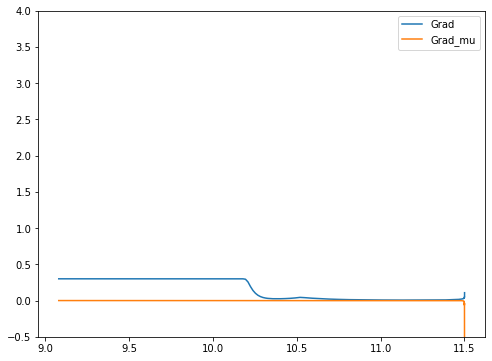

In [31]:
dlgZgr1 = np.gradient(lgZgr['g'], domain.grid(0))
dlgP = lgP.differentiate('r')

# Multiply dlgZgr by Zgr to get dZgr (as a proxy for dmu = d(1+Zgr) = dZgr)
grad_mu= dlgZgr1/ dlgP['g'] 
grad_mu *= np.exp(lgZgr['g'])

#grad_mu.evaluate()
#grad_mu.require_grid_space()

plt.figure(figsize=(8,6))
plt.plot(R, Grad['g'], label='Grad')
#plt.plot(R, dlgZgr['g'] / dlgP['g'], label='Grad_mu')
plt.plot(R, grad_mu, label='Grad_mu')
plt.ylim(-0.5, 4)
plt.legend()

/tmp/ipykernel_1382/2442247272.py:5: RuntimeWarning: invalid value encountered in log10
  plt.plot(R, np.log10(R_0), label='log10(R_0)')


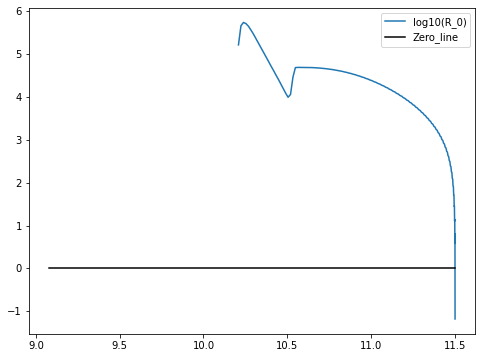

In [32]:
# Plot R_0 for fingering convection
R_0 = (Grad['g'] - grad_ad)/grad_mu

plt.figure(figsize=(8,6))
plt.plot(R, np.log10(R_0), label='log10(R_0)')
plt.plot(R, 0*R , 'k-', label='Zero_line')
#plt.ylim(-1.0, 1000.0)
plt.legend()


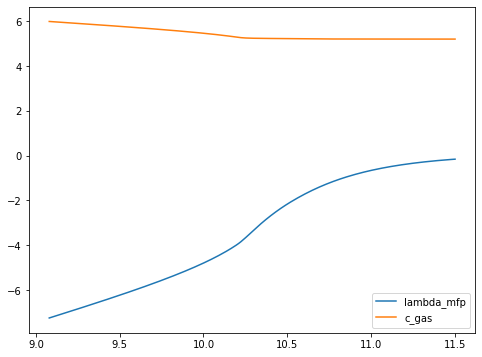

In [33]:
# Profile of nu and Xi for Prandtl number
c_gas=np.sqrt(8.32e7 * np.exp(lgt)*T_0 )
cross_sect_H2=2e-15 #cgs H2 cross section
lambda_mfp= 1./ (cross_sect_H2 * rho_gas['g'] / 2 / 1.67e-24)
nu_visc= lambda_mfp * c_gas

plt.figure(figsize=(8,6))
plt.plot(R, np.log10(lambda_mfp), label='lambda_mfp')
plt.plot(R, np.log10(c_gas), label='c_gas')

#plt.ylim(-0.1, 0.1)
plt.legend()       

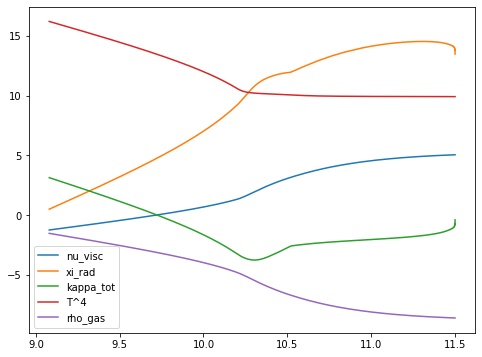

In [34]:
gas_gamma=7./5.
kappa_tot =  kappa.evaluate()
kappa_tot.require_grid_space()
#xi_rad= 16./3. * (gas_gamma-1)/gas_gamma * 5.670367e-5 * (np.exp(lgt['g'])*T_0)**4.  / rho_gas['g'] / np.exp(lgP['g']) 
xi_rad= 16./3. * (gas_gamma-1)/gas_gamma * 5.670367e-5 * (np.exp(lgt)*T_0)**4.  / rho_gas['g'] / kappa_tot['g']/ np.exp(lgP['g'])

plt.figure(figsize=(8,6))
plt.plot(R, np.log10(nu_visc), label='nu_visc')
plt.plot(R, np.log10(xi_rad), label='xi_rad')

plt.plot(R, np.log10(kappa_tot['g']), label='kappa_tot')

plt.plot(R, np.log10((np.exp(lgt)*T_0)**4.), label='T^4')
plt.plot(R, np.log10(rho_gas['g']), label='rho_gas')

#plt.ylim(-0.1, 0.1)
plt.legend()

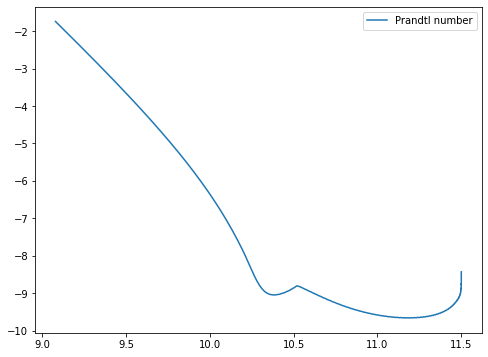

In [35]:
# Profile of Prandtl number
plt.figure(figsize=(8,6))
plt.plot(R, np.log10(nu_visc/xi_rad), label='Prandtl number')
#plt.plot(R, np.log10(xi_rad), label='xi_rad')

#plt.ylim(-0.1, 0.1)
plt.legend()

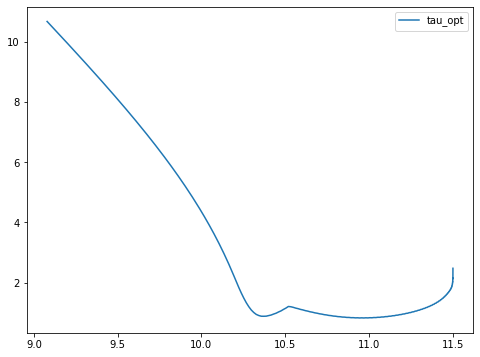

In [36]:
# Optical thickness to 'surface'
tau_opt= 10.**R * rho_gas['g'] *kappa_tot['g'] # Approximation to true integral of rho.dz

plt.figure(figsize=(8,6))
plt.plot(R, np.log10(tau_opt), label='tau_opt')
#plt.plot(R, np.log10(xi_rad), label='xi_rad')

#plt.ylim(-0.1, 0.1)
plt.legend()


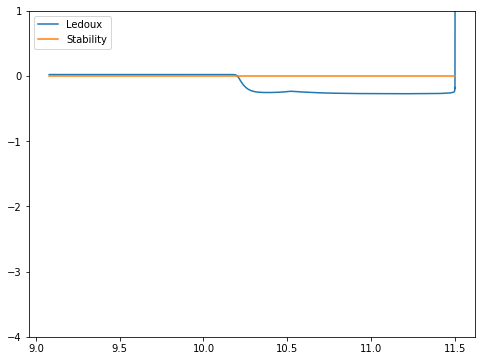

In [37]:
plt.figure(figsize=(8,6))
plt.plot(R, Grad['g'] - grad_mu - grad_ad, label='Ledoux')
plt.plot(R, 0*R , label='Stability')
plt.ylim(-4, 1)
plt.legend()

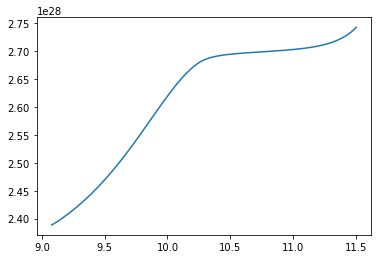

In [38]:
# This should be the mass 
plt.plot(R, Core_mass+Env)
plt.show()

In [39]:
Cs = cg.evaluate() # sound speed, which we previously used 
Cs.require_grid_space()
Cs = Cs['g']

Nth = np.sqrt((G*(Core_mass+Env)/(10**R)**2)**2/Cs**2*(grad_ad-Grad_rad['g'])) # I changed grad_rad to be positive now
d_finger= ((nu_visc*xi_rad)/Nth**2)**(1/4)
tau_cool = d_finger**2/xi_rad

Rgas = 8.32e7 / 2.3 # You gave me this value, but the wikipedia one in cgs doesnt have the /2.3 
Sigma = 5.7e-5
tau_cool_thin = Rgas/(16*kappa_tot['g']*Sigma*(np.exp(lgt)*T_0)**3)

Prandtl = nu_visc/xi_rad 

v_coll = d_finger/(np.sqrt(Prandtl)*tau_cool)

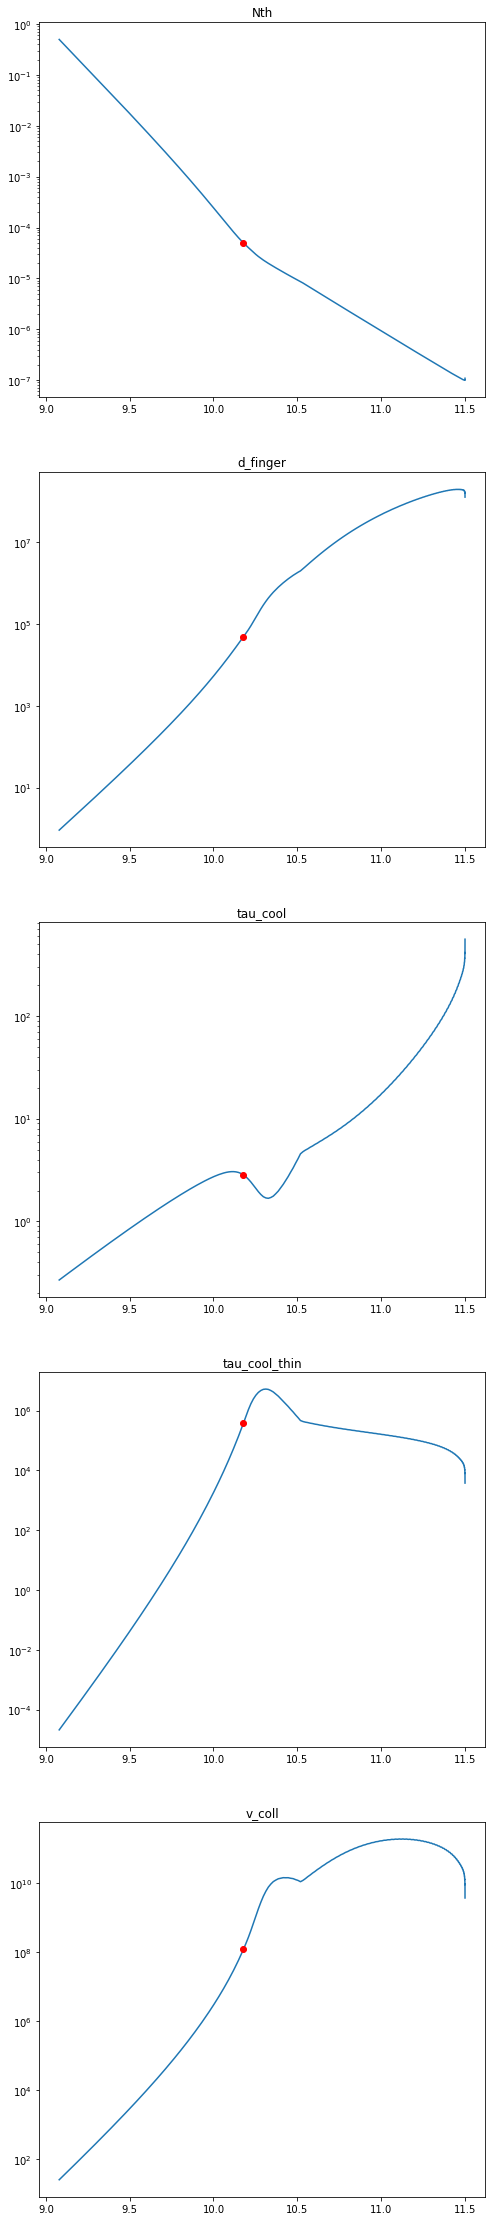

In [40]:
# red dot marks where grad transitions to grad_rad

plt.figure(figsize=(8,8*5))

plt.subplot(5,1,1)
plt.plot(R, Nth)
plt.plot(R[RCB], Nth[RCB], 'ro')
plt.yscale('log')
plt.title('Nth')

plt.subplot(5,1,2)
plt.plot(R,d_finger)
plt.plot(R[RCB], d_finger[RCB], 'ro')
plt.title('d_finger')
plt.yscale('log')

plt.subplot(5,1,3)
plt.plot(R,tau_cool)
plt.plot(R[RCB], tau_cool[RCB], 'ro')
plt.title('tau_cool')
plt.yscale('log')

plt.subplot(5,1,4)
plt.plot(R,tau_cool_thin)
plt.plot(R[RCB], tau_cool_thin[RCB], 'ro')
plt.title('tau_cool_thin')
plt.yscale('log')

plt.subplot(5,1,5)
plt.plot(R,v_coll)
plt.plot(R[RCB], v_coll[RCB], 'ro')
plt.title('v_coll')
plt.yscale('log')

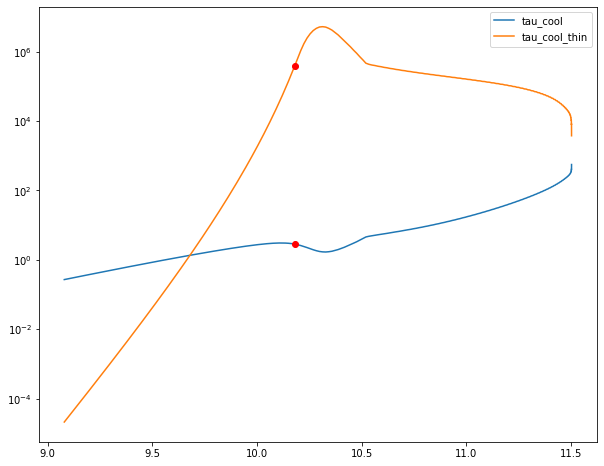

In [41]:
plt.figure(figsize=(10,8))
plt.plot(R,tau_cool, label='tau_cool')
plt.plot(R, tau_cool_thin, label='tau_cool_thin')
plt.plot(R[RCB], tau_cool[RCB], 'ro')
plt.plot(R[RCB], tau_cool_thin[RCB], 'ro')
plt.yscale('log')
plt.legend()
plt.show()

In [42]:
np.savetxt("NPressure_dep.txt", lgP_list[-1])
np.savetxt("NTemperature_dep.txt", lgT_list[-1])
np.savetxt("NZgr_dep.txt", lgZgr_list[-1])
np.savetxt("NM_dep.txt", lgM_list[-1])
np.savetxt("Nm_dep.txt",  m_list[-1])
np.savetxt("NL_dep.txt", L_list[-1])

In [43]:
prefix = '1_4_'

np.savetxt('saved/'+prefix+'Ngrad.txt', Grad['g'])
np.savetxt('saved/'+prefix+'Ngrad_rad.txt', Grad_rad['g'])
np.savetxt('saved/'+prefix+'NTstop.txt', np.log10(TStop['g']))
np.savetxt('saved/'+prefix+'NTgrow.txt', np.log10(TGrow['g']))
np.savetxt('saved/'+prefix+'NTsettl.txt', Tsettl) 
np.savetxt('saved/'+prefix+'NZgr.txt', np.exp(lgZgr['g'])) 
np.savetxt('saved/'+prefix+'Nkappa_gr.txt', kappa_gr['g']) 
np.savetxt('saved/'+prefix+'Nsize.txt', size['g'])
np.savetxt('saved/'+prefix+'Nrho_gas_cbrt.txt', (rho_gas['g'])**(1/3))
np.savetxt('saved/'+prefix+'NTemperature.txt', np.exp(lgt)*T_0)
np.savetxt('saved/'+prefix+'NPress.txt', np.exp(lgt)*T_0 *rho_gas['g'])
np.savetxt('saved/'+prefix+'Nrho_gas_norm.txt', (rho_gas['g']/rhodisk)**(1/3))
np.savetxt('saved/'+prefix+'NTemperature_norm.txt',np.exp(lgt)*T_0 / Tdisk)
np.savetxt('saved/'+prefix+'NEnv.txt', Env)
np.savetxt('saved/'+prefix+'Ngrad_mu.txt', grad_mu)
np.savetxt('saved/'+prefix+'Ngrad_ad.txt', grad_ad*np.ones(len(R)))
np.savetxt('saved/'+prefix+'Nlog10(R_0).txt',  np.log10(R_0))
np.savetxt('saved/'+prefix+'Nlambda_mfp.txt',  np.log10(lambda_mfp))
np.savetxt('saved/'+prefix+'Nc_gas.txt',  np.log10(c_gas))
np.savetxt('saved/'+prefix+'Nnu_visc.txt',  np.log10(nu_visc))
np.savetxt('saved/'+prefix+'Nxi_rad.txt',  np.log10(xi_rad))
np.savetxt('saved/'+prefix+'Nkappa_tot.txt',  np.log10(kappa_tot['g']))
np.savetxt('saved/'+prefix+'NTfourth.txt',  np.log10((np.exp(lgt)*T_0)**4.))
np.savetxt('saved/'+prefix+'Nrho_gas.txt',  np.log10(rho_gas['g']))
np.savetxt('saved/'+prefix+'NPrandtl_number.txt',  np.log10(nu_visc/xi_rad))
np.savetxt('saved/'+prefix+'Ntau_opt.txt',  np.log10(tau_opt))
np.savetxt('saved/'+prefix+'NLedoux.txt',  Grad['g'] - grad_mu - grad_ad)
np.savetxt('saved/'+prefix+'NR.txt', R)

/tmp/ipykernel_1382/4125081225.py:19: RuntimeWarning: invalid value encountered in log10
  np.savetxt('saved/'+prefix+'Nlog10(R_0).txt',  np.log10(R_0))


# New section Oct 13 (Kristen - evaluate diffusion times vs settling)

In [44]:
# Growth time of fingers (thick/thin)
#tau_growth_thick = np.sqrt(Prandtl) * tau_cool
#tau_growth_thin  = np.sqrt(Prandtl) * tau_cool_thin
tau_growth_thick = 1./np.sqrt(Prandtl / R_0) * tau_cool
tau_growth_thin  = 1./np.sqrt(Prandtl / R_0) * tau_cool_thin



# Diffusion coeff from fingers (thick/thin)
diff_thick = d_finger**2 / tau_growth_thick
diff_thin = d_finger**2 / tau_growth_thin

# Local Diffusion time from fingers (thick/thin)
tau_diff_thick = (10**R)**2 / diff_thick 
tau_diff_thin = (10**R)**2 / diff_thin

# Collision velocity
v_coll_thick = d_finger / tau_growth_thick

/tmp/ipykernel_1382/3067597994.py:4: RuntimeWarning: invalid value encountered in sqrt
  tau_growth_thick = 1./np.sqrt(Prandtl / R_0) * tau_cool
/tmp/ipykernel_1382/3067597994.py:5: RuntimeWarning: invalid value encountered in sqrt
  tau_growth_thin  = 1./np.sqrt(Prandtl / R_0) * tau_cool_thin


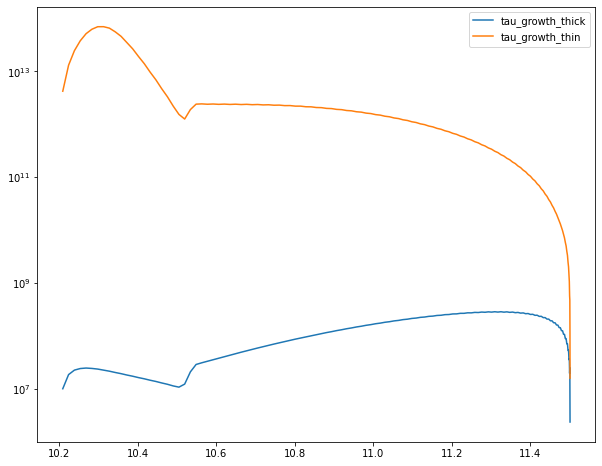

In [45]:
plt.figure(figsize=(10,8))
plt.plot(R,tau_growth_thick, label='tau_growth_thick')
plt.plot(R, tau_growth_thin, label='tau_growth_thin')
#plt.plot(R[RCB], tau_cool[RCB], 'ro')
#plt.plot(R[RCB], tau_cool_thin[RCB], 'ro')
plt.yscale('log')
plt.legend()
plt.show()

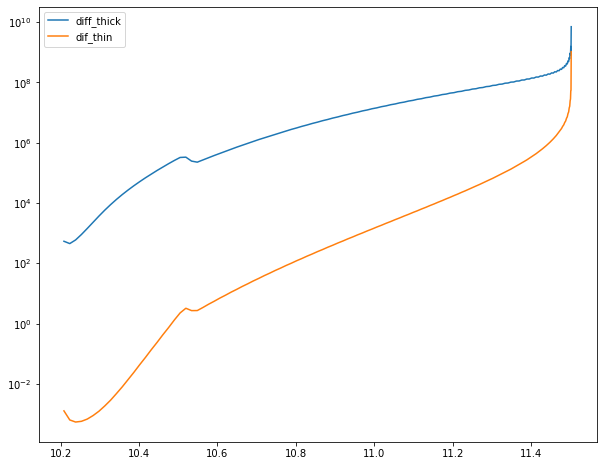

In [46]:
plt.figure(figsize=(10,8))
plt.plot(R,diff_thick, label='diff_thick')
plt.plot(R, diff_thin, label='dif_thin')
#plt.plot(R[RCB], tau_cool[RCB], 'ro')
#plt.plot(R[RCB], tau_cool_thin[RCB], 'ro')
plt.yscale('log')
plt.legend()
plt.show()

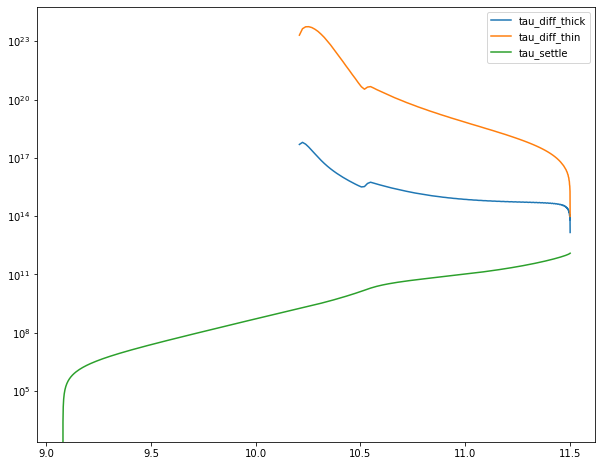

In [47]:
plt.figure(figsize=(10,8))
plt.plot(R,tau_diff_thick, label='tau_diff_thick')
plt.plot(R, tau_diff_thin, label='tau_diff_thin')
plt.plot(R, Tsettl, label='tau_settle')
#plt.plot(R[RCB], tau_cool[RCB], 'ro')
#plt.plot(R[RCB], tau_cool_thin[RCB], 'ro')
plt.yscale('log')
plt.legend()
plt.show()


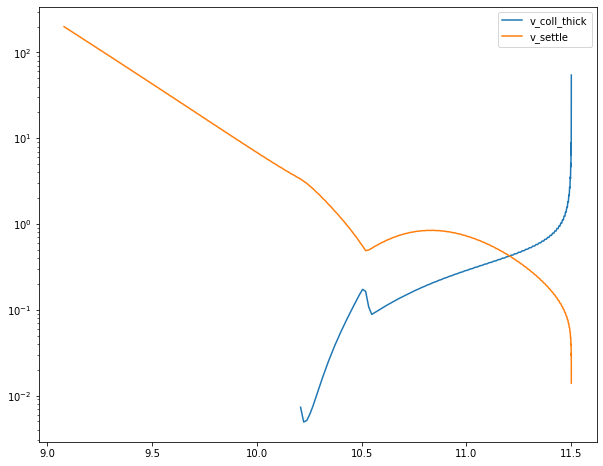

In [48]:
plt.figure(figsize=(10,8))
plt.plot(R,v_coll_thick, label='v_coll_thick')
plt.plot(R,Vset, label='v_settle')
#plt.plot(R[RCB], d_finger[RCB], 'ro')
#plt.title('d_finger')
plt.yscale('log')
plt.legend()
plt.show()

# New section Oct 14 (using a new optically thin expression for finger size + optically-thin cooling time)

In [49]:
new_d_finger = np.sqrt(nu_visc / Nth**2 / tau_cool_thin)

# Growth time of fingers 
#new_tau_growth_thin  = np.sqrt(Prandtl) * tau_cool_thin
new_tau_growth_thin  = 1./np.sqrt(Prandtl/R_0) * tau_cool_thin

# Diffusion coeff from fingers 
new_diff_thin = new_d_finger**2 / new_tau_growth_thin

# Local Diffusion time from fingers 
new_tau_diff_thin = (10**R)**2 / new_diff_thin

# Collision velocity
new_v_coll = new_d_finger / new_tau_growth_thin

/tmp/ipykernel_1382/2124649967.py:5: RuntimeWarning: invalid value encountered in sqrt
  new_tau_growth_thin  = 1./np.sqrt(Prandtl/R_0) * tau_cool_thin


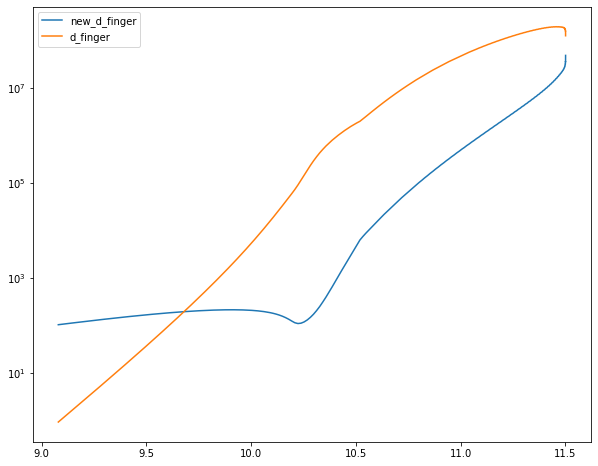

In [50]:
plt.figure(figsize=(10,8))
plt.plot(R,new_d_finger, label='new_d_finger')
plt.plot(R,d_finger, label='d_finger')
#plt.plot(R[RCB], d_finger[RCB], 'ro')
#plt.title('d_finger')
plt.yscale('log')
plt.legend()
plt.show()

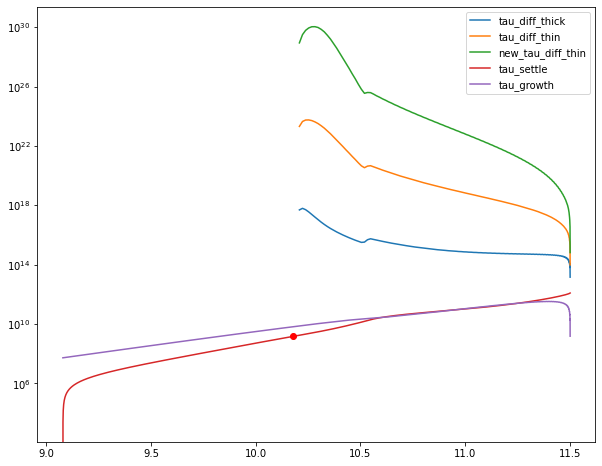

In [51]:
plt.figure(figsize=(10,8))
plt.plot(R, tau_diff_thick, label='tau_diff_thick')
plt.plot(R, tau_diff_thin, label='tau_diff_thin')
plt.plot(R, new_tau_diff_thin, label='new_tau_diff_thin')
plt.plot(R, Tsettl, label='tau_settle')
plt.plot(R, TGrow['g'], label='tau_growth')
plt.plot(R[RCB], Tsettl[RCB], 'ro')

plt.yscale('log')
plt.legend()
plt.show()

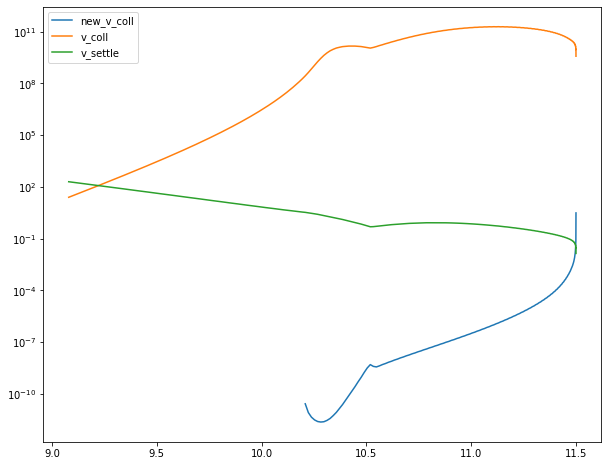

In [52]:
plt.figure(figsize=(10,8))
plt.plot(R,new_v_coll, label='new_v_coll')
plt.plot(R,v_coll, label='v_coll')
plt.plot(R,Vset, label='v_settle')
#plt.plot(R[RCB], d_finger[RCB], 'ro')
#plt.title('d_finger')
plt.yscale('log')
plt.legend()
plt.show()

# New section Oct 26: fingers must be larger to cool more slowly.

# Just make fingers larger for slower cooling time (to avoid viscous dissipation), keep all other scalings as original Brown+ theory

In [53]:
# From: tau_cool = d_finger**2/xi_rad
d_finger_eff = np.sqrt(xi_rad * tau_cool_thin)

# 

tau_cool_eff = tau_cool_thin # effective cooling time is tau_cool_thin

# Then use all optically thick formalism with d_finger_eff (cooling time is now thin one):

# Growth time of fingers 
#tau_growth_eff =  tau_cool_eff
tau_growth_eff = 1./np.sqrt(Prandtl) * tau_cool_eff
#tau_growth_eff = 1./np.sqrt(Prandtl / R_0) * tau_cool_eff  

# Diffusion coeff from fingers 
diff_eff = d_finger_eff**2 / tau_growth_eff

#diff_theory = np.sqrt(xi_rad**2 * Prandtl)
#diff_eff = diff_theory

# Local Diffusion time from fingers 
tau_diff_eff = (10**R)**2 / diff_eff 

# Velocity collision
v_coll_eff = d_finger_eff / tau_growth_eff

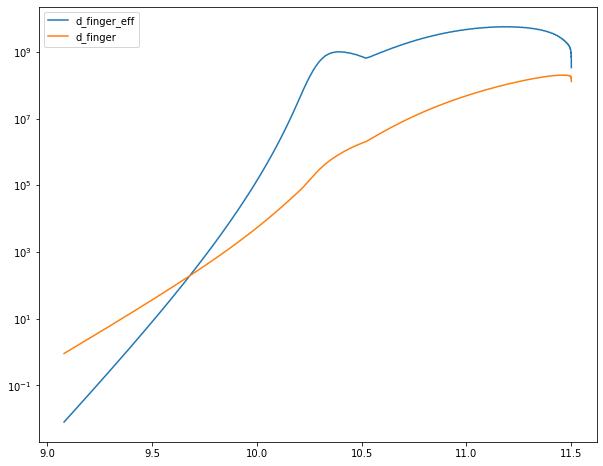

In [54]:
plt.figure(figsize=(10,8))
plt.plot(R,d_finger_eff, label='d_finger_eff')
plt.plot(R,d_finger, label='d_finger')
#plt.plot(R[RCB], d_finger[RCB], 'ro')
#plt.title('d_finger')
plt.yscale('log')
plt.legend()
plt.show()


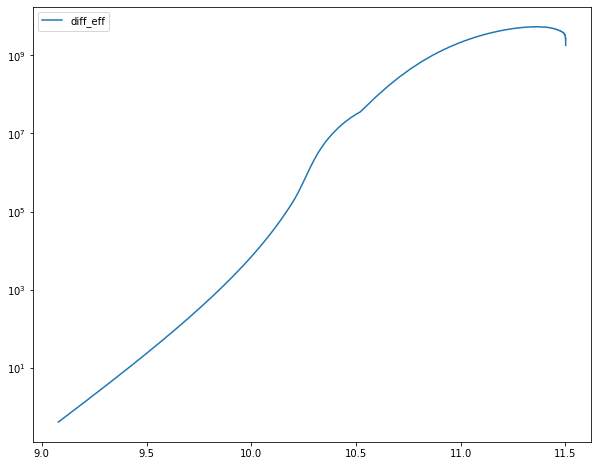

In [55]:
plt.figure(figsize=(10,8))
plt.plot(R,diff_eff, label='diff_eff')
#plt.plot(R,d_finger, label='d_finger')
#plt.plot(R[RCB], d_finger[RCB], 'ro')
#plt.title('d_finger')
plt.yscale('log')
plt.legend()
plt.show()


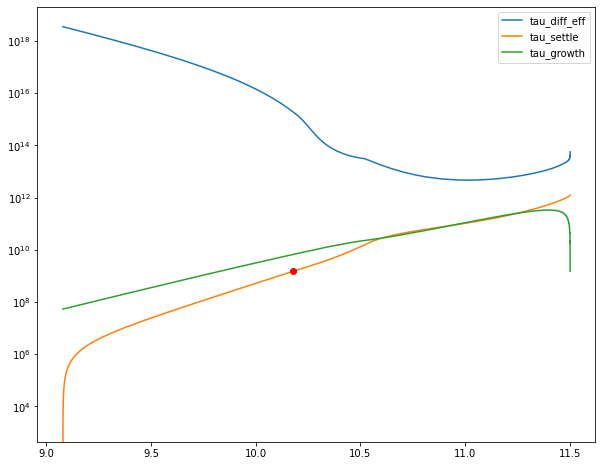

In [56]:
plt.figure(figsize=(10,8))
plt.plot(R, tau_diff_eff, label='tau_diff_eff')
plt.plot(R, Tsettl, label='tau_settle')
plt.plot(R, TGrow['g'], label='tau_growth')
plt.plot(R[RCB], Tsettl[RCB], 'ro')

plt.yscale('log')
plt.legend()
plt.show()

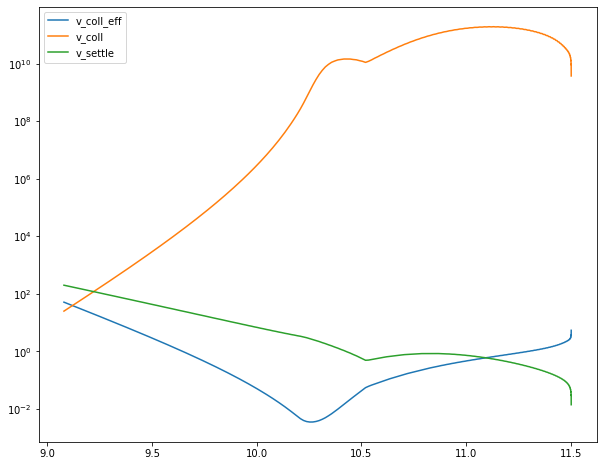

In [57]:
plt.figure(figsize=(10,8))
plt.plot(R,v_coll_eff, label='v_coll_eff')
plt.plot(R,v_coll, label='v_coll')
plt.plot(R,Vset, label='v_settle')
#plt.plot(R[RCB], d_finger[RCB], 'ro')
#plt.title('d_finger')
plt.yscale('log')
plt.legend()
plt.show()

# New section Oct 27: Stern number from Brown + 2013

In [58]:
# We use intermediate regime Tau,Prandtl << r << 1. Eqns 36 & 37 of Brown+ 

X_mu =1.0e0 # reduction factor for compositional of dust, relative to viscosity
Prandtl_mu = X_mu * Prandtl # written Tau in Brown : ratio of compositional diffusion to thermal diffusion
r_Brown = (R_0 -1) / (1./Prandtl_mu - 1)


C = 7.0 # Calibration constant

Nusselt_T = 1 + C**2 * Prandtl * Prandtl_mu * (1 + Prandtl_mu / Prandtl) / r_Brown
Nusselt_mu = 1 + C**2 * np.sqrt(Prandtl / Prandtl_mu) * np.sqrt((1 + Prandtl_mu / Prandtl) / r_Brown)

/tmp/ipykernel_1382/120840444.py:11: RuntimeWarning: invalid value encountered in sqrt
  Nusselt_mu = 1 + C**2 * np.sqrt(Prandtl / Prandtl_mu) * np.sqrt((1 + Prandtl_mu / Prandtl) / r_Brown)


In [59]:
# Stern number A

gamma_turb = R_0 * (Nusselt_T -1) /  (Nusselt_mu -1) / Prandtl_mu
A = (Nusselt_T -1) * (1./gamma_turb -1) / Prandtl / (1 - 1./R_0)

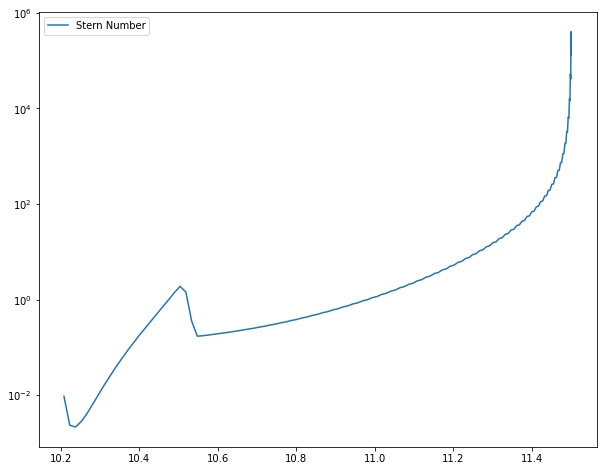

In [60]:
plt.figure(figsize=(10,8))
plt.plot(R,A, label='Stern Number')

plt.yscale('log')
plt.legend()
plt.show()

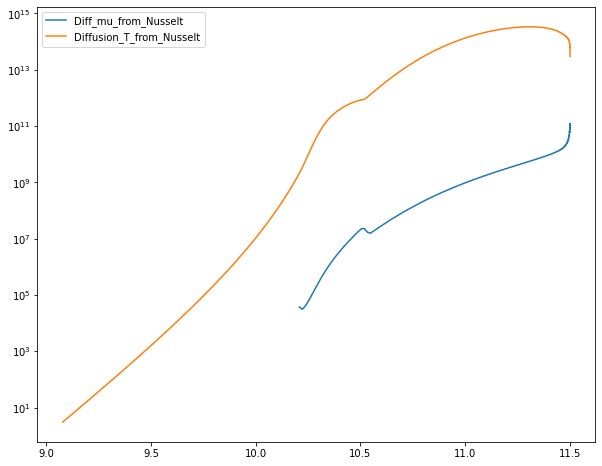

In [61]:
plt.figure(figsize=(10,8))
plt.plot(R,Nusselt_mu * Prandtl * xi_rad , label='Diff_mu_from_Nusselt')
plt.plot(R,Nusselt_T * xi_rad, label='Diffusion_T_from_Nusselt')
plt.yscale('log')
plt.legend()
plt.show()